# House Price Prediction based on Clustered Neighborhoods <br><br> in King County, USA

Import required libraries

In [40]:
import pandas as pd
import numpy as np
import folium
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

<H2> Exploratory Data Analysis <H2>

In [34]:
pd.set_option('display.max_columns', 500)
kc_house_data = pd.read_csv('housesalesprediction/kc_house_data.csv')

In [37]:
kc_house_data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


[]

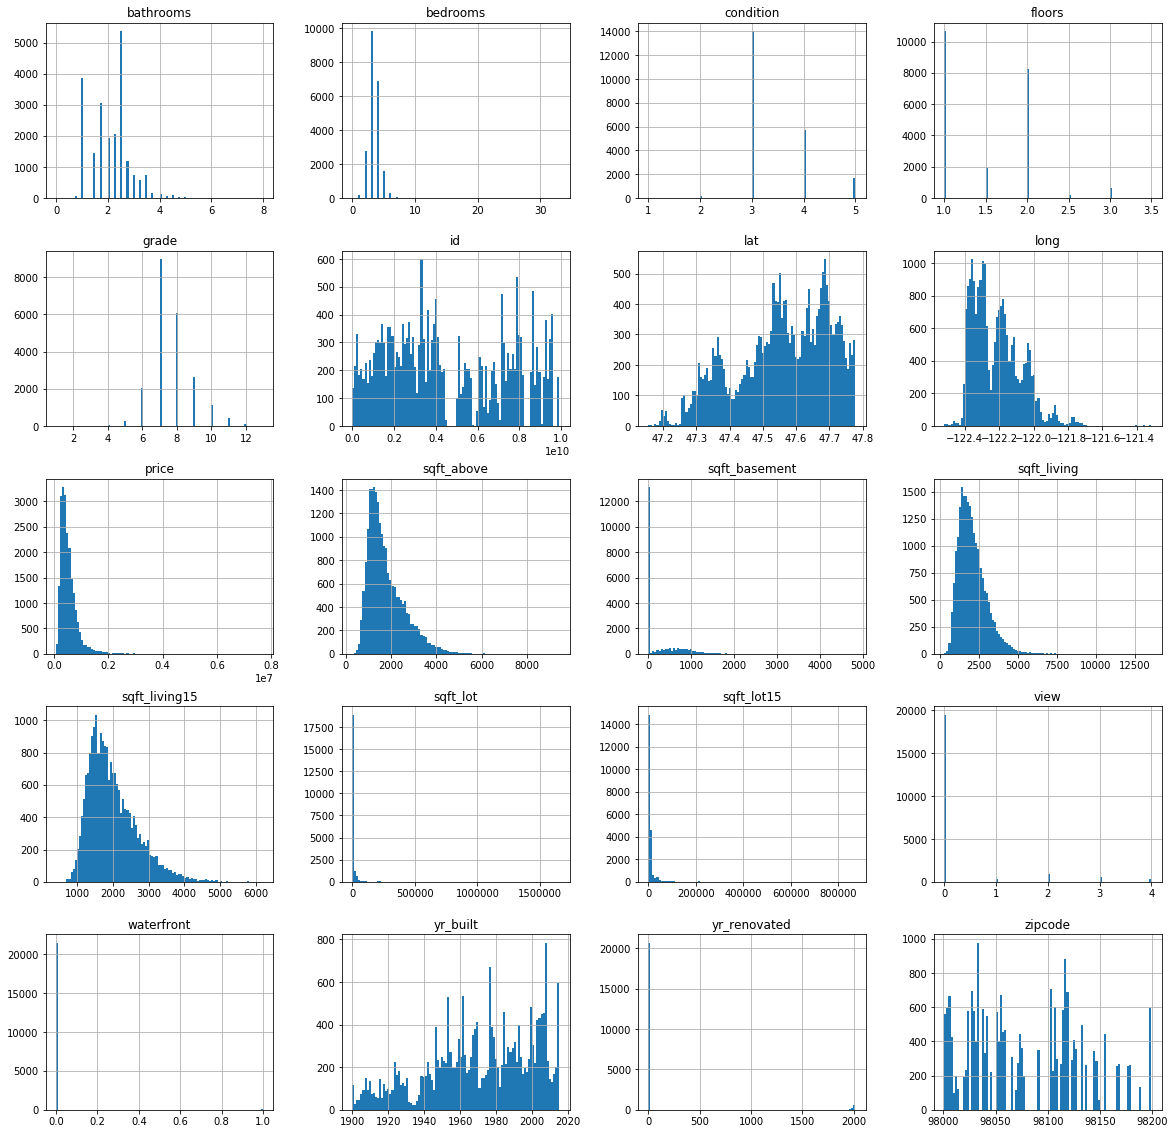

In [48]:
kc_house_data.hist(bins=100,figsize=(20,20))
plt.plot()

<H3> Analyze location data for Toronto </H3>
<br> Find the coordinates for Toronto using Nominatim from geopy

In [25]:
address = "98019, USA"
geolocator = Nominatim(user_agent='explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("Coordinates: {}, {}".format(latitude,longitude))

Coordinates: 47.740791333963, -121.97229674284


Mark all the points from the Toronto location dataframe in the map

In [27]:
to_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for idx, row in toronto_location_df.iterrows():
    label = row['PostalCode']
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius=3, color='Blue', fill=True, fill_color='Blue', fill_opacity=1,
        popup=label
    ).add_to(to_map)

to_map

<h3>Connecting with FourSquare</h3>
<br>Use credentials to create URL and retrive data for Toronto

In [9]:
CLIENT_ID = 'RGCS4PAOYAAUQTN3ZARIVIE4YV4U3U5BCODVVRAP4ONWJHLV' # your Foursquare ID
CLIENT_SECRET = '4IUJ2SWB3AEJY0IR4W5JBEOLI5330TY2MTUMH5OZPCRB31TP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RGCS4PAOYAAUQTN3ZARIVIE4YV4U3U5BCODVVRAP4ONWJHLV
CLIENT_SECRET:4IUJ2SWB3AEJY0IR4W5JBEOLI5330TY2MTUMH5OZPCRB31TP


In [20]:
radius=5000
limit=100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.\
format(CLIENT_ID,CLIENT_SECRET,VERSION,to_latitude,to_longitude,radius,limit)

Analyze the JSON file retrieved. Notice the important keys as it would help in creating the dataframe for further analysis.

In [21]:
results = requests.get(url).json()

In [22]:
results

{'meta': {'code': 200, 'requestId': '5cce81564434b93150fd8090'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Mumbai',
  'headerFullLocation': 'Mumbai',
  'headerLocationGranularity': 'city',
  'totalResults': 176,
  'suggestedBounds': {'ne': {'lat': 18.983771145000045,
    'lng': 72.88282217042931},
   'sw': {'lat': 18.893771054999956, 'lng': 72.78784882957069}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4caa0096d971b1f7ccca23e1',
       'name': 'Royal China',
       'location': {'address': 'Waudby Road',
        'lat': 18.938715239156295,
        'lng': 72.83293313173236,
        'labeledLatLngs': [{'label': 'display',
          'lat': 18.938715239156295,
          'lng'

In [23]:
groups = results['response']['groups']
json_normalize(groups)

,items,name,type
0,"[{'reasons': {'count': 0, 'items': [{'summary'...",recommended,Recommended Places


Convert the venues retrieved from JSON data to a pandas dataframe

In [24]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

In [25]:
nearby_venues.shape

(100, 22)

<H4> Find how to retrieve category from the column 'categories'<H4>

In [26]:
filtered_cols = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues[filtered_cols]
cols = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.columns=cols
nearby_venues.head()

,name,categories,lat,lng
0,Royal China,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",18.938715,72.832933
1,Starbucks,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",18.932190,72.833959
2,Food for Thought,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",18.932031,72.831667
3,Britannia & Co.,"[{'id': '54135bf5e4b08f3d2429dfef', 'name': 'P...",18.934683,72.840183
4,Yazdani Bakery,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",18.933191,72.833591


In [27]:
nearby_venues['categories'] = nearby_venues['categories'].apply(lambda x: x[0]['name'])

List all the unique categories retrieved and display the frequency for each.

In [28]:
nearby_venues['categories'].value_counts()

Indian Restaurant            11
Café                          8
Hotel                         5
Ice Cream Shop                5
Coffee Shop                   3
Seafood Restaurant            3
Cricket Ground                3
Bar                           3
Pizza Place                   3
Mughlai Restaurant            2
Dessert Shop                  2
Lounge                        2
Breakfast Spot                2
Monument / Landmark           2
Chinese Restaurant            2
Scenic Lookout                2
Fast Food Restaurant          2
Cocktail Bar                  2
Bookstore                     2
Mediterranean Restaurant      2
Diner                         2
Art Gallery                   1
Athletics & Sports            1
Italian Restaurant            1
Stadium                       1
Chaat Place                   1
Cheese Shop                   1
Bakery                        1
Nightclub                     1
Clothing Store                1
Theater                       1
History 

<H3> Create a function to create the venues dataframe which will only contain the necessary columns required for data analyis.

In [16]:
radius = 500
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
toronto_venues = getNearbyVenues(toronto_location_df['Neighborhood'], 
                                 toronto_location_df['Latitude'], 
                                 toronto_location_df['Longitude'])

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques categories.


<H3> Segmentation </H3>
<br> Convert the dataframe to one hot encoding so that we can find the frequency for each neighborhood and then later compute mean and find the top 10 categories for each neighborhood.

In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
col_list = list(toronto_onehot.columns)
col_list.remove('Neighborhood')
fixed_columns = ["Neighborhood"] + col_list
toronto_onehot = toronto_onehot[fixed_columns]

In [20]:
toronto_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Highland Creek, Rouge Hill, Port Union",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
toronto_onehot.shape

(2244, 274)

In [50]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

NameError: name 'toronto_onehot' is not defined

In [23]:
toronto_grouped.shape

(100, 274)

Create a dataframe to store the top 10 venues for each of the neighborhoods.

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,American Restaurant,Steakhouse,Bakery,Bar,Burger Joint,Hotel,Salad Place
1,Agincourt,Lounge,Skating Rink,Sandwich Place,Breakfast Spot,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Empanada Restaurant,Dessert Shop,Drugstore
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Coffee Shop,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pharmacy,Coffee Shop,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Beer Store,Pizza Place,Dumpling Restaurant,Drugstore
4,"Alderwood, Long Branch",Pizza Place,Gym,Athletics & Sports,Coffee Shop,Pharmacy,Skating Rink,Sandwich Place,Pool,Pub,Diner


<H3> Clustering </H3>
<br> Create clusters using KMeans and then plot them on a map after joining the two dataframes.

In [26]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1])

In [27]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,American Restaurant,Steakhouse,Bakery,Bar,Burger Joint,Hotel,Salad Place
1,Agincourt,Lounge,Skating Rink,Sandwich Place,Breakfast Spot,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Empanada Restaurant,Dessert Shop,Drugstore
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Coffee Shop,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pharmacy,Coffee Shop,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Beer Store,Pizza Place,Dumpling Restaurant,Drugstore
4,"Alderwood, Long Branch",Pizza Place,Gym,Athletics & Sports,Coffee Shop,Pharmacy,Skating Rink,Sandwich Place,Pool,Pub,Diner
5,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Pet Store,Sandwich Place,Middle Eastern Restaurant,Supermarket,Deli / Bodega,Bank,Fried Chicken Joint,Frozen Yogurt Shop,Fast Food Restaurant
6,Bayview Village,Bank,Café,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
7,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Fast Food Restaurant,Pub,Pizza Place,Butcher,Sushi Restaurant,Indian Restaurant,Breakfast Spot,Juice Bar
8,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Café,Beer Bar,Farmers Market,Seafood Restaurant,Bakery,Steakhouse,Cheese Shop
9,"Birch Cliff, Cliffside West",General Entertainment,College Stadium,Café,Skating Rink,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant


In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_location_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = neighborhoods_venues_sorted.join(toronto_merged.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,PostalCode,Borough,Latitude,Longitude
0,1,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,American Restaurant,Steakhouse,Bakery,Bar,Burger Joint,Hotel,Salad Place,M5H,Downtown Toronto,43.650571,-79.384568
1,1,Agincourt,Lounge,Skating Rink,Sandwich Place,Breakfast Spot,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Empanada Restaurant,Dessert Shop,Drugstore,M1S,Scarborough,43.794200,-79.262029
2,4,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Coffee Shop,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,M1V,Scarborough,43.815252,-79.284577
3,1,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pharmacy,Coffee Shop,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Beer Store,Pizza Place,Dumpling Restaurant,Drugstore,M9V,Etobicoke,43.739416,-79.588437
4,1,"Alderwood, Long Branch",Pizza Place,Gym,Athletics & Sports,Coffee Shop,Pharmacy,Skating Rink,Sandwich Place,Pool,Pub,Diner,M8W,Etobicoke,43.602414,-79.543484


In [29]:
# create map
map_clusters = folium.Map(location=[to_latitude, to_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

From the above map, we can infer that we have two major clusters - purple and orange ones. Let us analyze and assign these clusters some names.

<H3> Cluster 1 - Coffee Shops and Restaurants

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, :]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,PostalCode,Borough,Latitude,Longitude
0,1,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,American Restaurant,Steakhouse,Bakery,Bar,Burger Joint,Hotel,Salad Place,M5H,Downtown Toronto,43.650571,-79.384568
1,1,Agincourt,Lounge,Skating Rink,Sandwich Place,Breakfast Spot,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Empanada Restaurant,Dessert Shop,Drugstore,M1S,Scarborough,43.794200,-79.262029
3,1,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pharmacy,Coffee Shop,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint,Beer Store,Pizza Place,Dumpling Restaurant,Drugstore,M9V,Etobicoke,43.739416,-79.588437
4,1,"Alderwood, Long Branch",Pizza Place,Gym,Athletics & Sports,Coffee Shop,Pharmacy,Skating Rink,Sandwich Place,Pool,Pub,Diner,M8W,Etobicoke,43.602414,-79.543484
5,1,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Pet Store,Sandwich Place,Middle Eastern Restaurant,Supermarket,Deli / Bodega,Bank,Fried Chicken Joint,Frozen Yogurt Shop,Fast Food Restaurant,M3H,North York,43.754328,-79.442259
6,1,Bayview Village,Bank,Café,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,M2K,North York,43.786947,-79.385975
7,1,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Fast Food Restaurant,Pub,Pizza Place,Butcher,Sushi Restaurant,Indian Restaurant,Breakfast Spot,Juice Bar,M5M,North York,43.733283,-79.419750
8,1,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Café,Beer Bar,Farmers Market,Seafood Restaurant,Bakery,Steakhouse,Cheese Shop,M5E,Downtown Toronto,43.644771,-79.373306
9,1,"Birch Cliff, Cliffside West",General Entertainment,College Stadium,Café,Skating Rink,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,M1N,Scarborough,43.692657,-79.264848
10,1,"Bloordale Gardens, Eringate, Markland Wood, Ol...",Pharmacy,Liquor Store,Café,Convenience Store,Beer Store,Pizza Place,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,M9C,Etobicoke,43.643515,-79.577201


<H3> Cluster 2 - Parks and Playgrounds

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, :]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,PostalCode,Borough,Latitude,Longitude
2,4,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Coffee Shop,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,M1V,Scarborough,43.815252,-79.284577
13,4,"CFB Toronto, Downsview East",Park,Airport,Snack Place,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,M3K,North York,43.737473,-79.464763
16,4,Caledonia-Fairbanks,Park,Pharmacy,Women's Store,Market,Fast Food Restaurant,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,M6E,York,43.689026,-79.453512
39,4,"Downsview, North Park, Upwood Park",Park,Massage Studio,Construction & Landscaping,Bakery,Yoga Studio,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant,M6L,North York,43.713756,-79.490074
41,4,East Toronto,Park,Convenience Store,Metro Station,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Yoga Studio,M4J,East York,43.685347,-79.338106
59,4,"Kingsview Village, Martin Grove Gardens, Richv...",Pizza Place,Park,Mobile Phone Shop,Bus Line,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,M9R,Etobicoke,43.688905,-79.554724
63,4,Lawrence Park,Bus Line,Park,Swim School,Construction & Landscaping,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,M4N,Central Toronto,43.728020,-79.388790
72,4,Parkwoods,Park,Fast Food Restaurant,Pool,Food & Drink Shop,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,M3A,North York,43.753259,-79.329656
74,4,Rosedale,Park,Playground,Trail,Yoga Studio,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,M4W,Downtown Toronto,43.679563,-79.377529
76,4,"Rouge, Malvern",Fast Food Restaurant,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Falafel Restaurant,M1B,Scarborough,43.806686,-79.194353


In [ ]:
pd.read